In [1]:
## Diabetes Health Indicators Dataset
### Comparison of resampling mechanisms.

### Import the required libraries.

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import fbeta_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from kmodes.kmodes import KModes
from minisom import MiniSom

from imblearn import FunctionSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from smote_variants import SUNDO
from sklearn.utils import Bunch
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import scipy.linalg as la
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### Load the dataset to use for this analysis.

In [3]:
# Load the data file and see what it looks like.
data_path = "/Volumes/Scratch/cdc/diabetes_binary_health_indicators_BRFSS2015.csv"
df = pd.read_csv(data_path, header=0)

### Emit some basic information to get a sense of what the data look like.

In [4]:
print(df.shape)
df.head()

(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [6]:
df.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [7]:
df.Diabetes_binary.value_counts(normalize = True)

Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

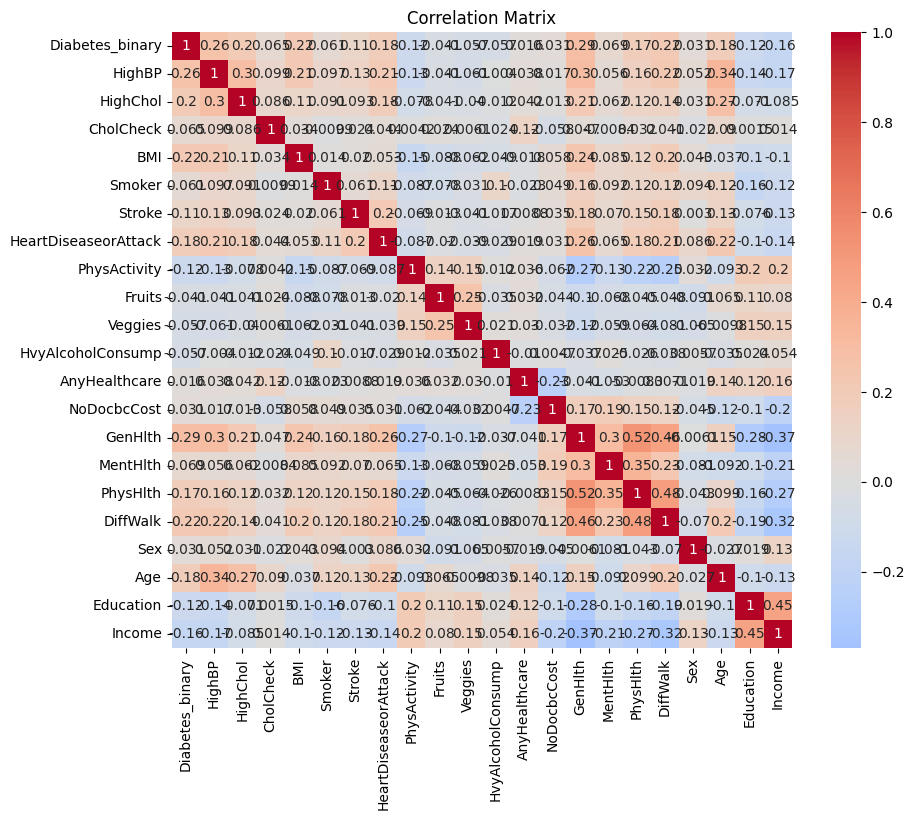

In [8]:
plt.figure(figsize = (10, 8))
corr_map = sns.heatmap(df.dropna().corr(), cmap = 'coolwarm', center = 0, annot = True)
corr_map.set_title('Correlation Matrix')
plt.savefig('img/cdc-corr-full.png', bbox_inches = 'tight')
plt.show()

### No particularly strong correlations seen.

In [9]:
df_sampled = df.sample(n=3000, random_state=42)
X = df_sampled.drop('Diabetes_binary', axis = 1)
y = df_sampled['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Diabetes_binary
0.0    0.851111
1.0    0.148889
Name: proportion, dtype: float64
Diabetes_binary
0.0    0.878667
1.0    0.121333
Name: proportion, dtype: float64


### Now the fun begins. We're going to attempt to implement proposed resampling methods.

In [10]:
def denoise(X, y, n_neighbors = 3):
    """
    Given a set of predictors and targets, determines which class is the minority and then looks for members
    of the minority class for which the closest neighbors are all in the majority. Those elements will be
    pruned from the set.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)
    noise = []
    
    # Identify which data points represent the minority.
    minority_indices = np.where(y == minority_class)

    # Get the indices of the closest neighbors for each minority sample and then loop over the collection.
    ind = knn.kneighbors(X[minority_indices], return_distance = False)
    for test_index in np.arange(len(ind)):
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]

        # Check for all of the others to _not_ be in the minority class and add to the noise list if that's the case.
        if np.all([y[i] != minority_class for i in neighbor_indices]):
            noise.append(test_index)

    print(f"Noisy samples: {np.array(noise)}")
    return np.delete(X, noise, axis = 0), np.delete(y, noise, axis = 0)

def get_category_indices(X, y, n_neighbors = 3):
    """
    Determine and return the sets of indices representing the minority, the boundary majority, and the remaining majority.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)

    # Get the minority indices ... that's the easy one.
    minority_indices = np.where(y == minority_class)
    
    bmaj = []
    obmaj = []
    majority_indices = np.where(y != minority_class)

    # Get the indices of the closest neighbors for each majority sample and then loop over the collection.
    ind = knn.kneighbors(X, return_distance = False)
    print(ind)
    for test_index in majority_indices[0]:
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]
        if np.any([y[i] == minority_class for i in neighbor_indices]):
            bmaj.append(test_index)
        else:
            obmaj.append(test_index)

    return minority_indices[0], np.array(bmaj), np.array(obmaj)

def sort_majority_samples(X):
    """
    Given a set of samples, return a list of indices into that collection sorted by descending distance to closest neighbor.
    """
    p = len(X[0])
    n = len(X)
    mat = np.zeros((n, n))
    for row in np.arange(n):
        for col in np.arange(n):
            if col == row:
                continue
            sum = np.zeros((p, p))
            for i in np.arange(n):
                q = X[i] - X[col]
                sum += np.outer(q, q)
            S_j = (1.0 / (n - 1)) * sum
            x = X[row] - X[col]
            mat[row, col] = (1.0 / p) * np.abs(np.dot(np.dot(x, np.linalg.inv(S_j)), x))

    # Now the distance between observations i and j is the minimum of mat[i,j] and mat[j,i]
    # For each entry we want to find the distance to its closest neighbor.
    pairs = []
    for obs in np.arange(n):
        row_vals = np.delete(mat[obs, :], obs)
        col_vals = np.delete(mat[:, obs], obs)
        pairs.append([obs, np.min(np.append(row_vals, col_vals))])
    nearest = np.array(pairs)
    sorted_indices = nearest[:, 1].argsort()[::-1]
    return sorted_indices

def anis_ali(X, y, random_state = 0):
    X_quiet, y_quiet = denoise(X, y)
    minority_indices, boundary_indices, majority_indices = get_category_indices(X_quiet, y_quiet)

    X_minority = X_quiet[minority_indices]
    y_minority = y_quiet[minority_indices]

    X_majority = X_quiet[majority_indices]
    y_majority = y_quiet[majority_indices]
    sorted_majority = sort_majority_samples(X_majority)

    X_resampled = np.append(X_minority, X_majority[:len(X_minority)], axis=0)
    y_resampled = np.append(y_minority, y_majority[:len(y_minority)], axis=0)
    return X_resampled, y_resampled

In [11]:
def relabel_clusters(labels, reference_labels, label_count):
    cost_matrix = np.zeros((len(np.unique(labels)), len(np.unique(reference_labels))))
    for i, l1 in enumerate(np.unique(labels)):
        for j, l2 in enumerate(np.unique(reference_labels)):
            cost_matrix[i, j] = -np.sum((labels == l1) & (reference_labels == l2))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {old_label:new_label for old_label, new_label in zip(np.unique(labels)[row_ind], np.unique(reference_labels)[col_ind])}
    mapped_labels = np.array([mapping[label] for label in labels])
    return mapped_labels
    
def onan(X, y, random_state = 0):
    majority_indices = np.where(y == 0)[0] # Assuming false is the majority class.
    minority_indices = np.where(y == 1)[0] # Assuming true is the minority class.
    n = len(majority_indices)
    m = len(minority_indices)
    num_clusters = m
    print(num_clusters)

    majority_predictors = X[majority_indices]

    cluster1 = KMeans(n_clusters = m, init = 'random', random_state = random_state)
    cluster2 = KModes(n_clusters = m, random_state = random_state)
    cluster3 = KMeans(n_clusters = m, random_state = random_state)
    cluster4 = MiniSom(m, 1, X.shape[1])
    cluster4.random_weights_init(X)
    cluster5 = AgglomerativeClustering(n_clusters = m, linkage = 'single')

    cluster1.fit(majority_predictors)
    cluster2.fit(majority_predictors)
    cluster3.fit(majority_predictors)
    cluster4.train_batch(majority_predictors, 5000)
    cluster5.fit(majority_predictors)

    part1 = cluster1.labels_
    part2 = relabel_clusters(cluster2.labels_, part1, num_clusters)
    part3 = relabel_clusters(cluster3.labels_, part1, num_clusters)
    part4 = relabel_clusters(np.array([int(cluster4.winner(x)[0]) for x in majority_predictors]), part1, num_clusters)
    part5 = relabel_clusters(cluster5.labels_, part1, num_clusters)

    all_parts = np.row_stack((part1, part2, part3, part4, part5))
    consensus_parts = stats.mode(all_parts).mode
    augmented = np.column_stack((majority_predictors, consensus_parts))
    maj_frame = pd.DataFrame(augmented)
    maj_means = maj_frame.groupby(maj_frame.columns[-1]).mean()

    # It's likely that in the course of consensus building we may lose some clusters, so pad it from the original data.
    supp_indices = np.random.choice(range(majority_predictors.shape[0]), max(0, m - maj_means.shape[0]), replace = False)

    X_new = np.row_stack((X[minority_indices], maj_means.to_numpy(), majority_predictors[supp_indices]))
    y_new = np.array([1] * m + [0] * maj_means.shape[0] + [0] * supp_indices.shape[0])
    
    return X_new, y_new

In [12]:
# Helper function to compute G-mean
def g_mean(y_true, y_pred):
    from sklearn.metrics import recall_score
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    return np.sqrt(sensitivity * specificity)

# Helper function to compute AUC-PR
def auc_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

# Function to compute IR ratio
def compute_ir_ratio(y):
    counts = np.bincount(y.astype(int))
    if len(counts) < 2:  # Ensure both classes are present
        return float('inf') if counts[0] > 0 else 0
    majority = max(counts)
    minority = min(counts)
    return majority / minority if minority > 0 else float('inf')

# Fisher Information Matrix (Equation 4)
def fisher_information(X, beta, lambda_reg):
    probs = 1 / (1 + np.exp(-X @ beta))
    W = np.diag(probs * (1 - probs))
    I = X.T @ W @ X + lambda_reg * np.eye(X.shape[1])
    return I

# MSEE computation (Equation 7)
def compute_msee(X_j, X_i, beta, lambda_reg, S_X, S_y):
    # Update Fisher information with X_i
    X_S = np.vstack([S_X, X_i])
    I_S_xi = fisher_information(X_S, beta, lambda_reg)
    I_inv = la.inv(I_S_xi)
    
    # Predicted probabilities
    pi_j = 1 / (1 + np.exp(-X_j @ beta))
    
    # Bias term
    bias_term = -pi_j * (1 - pi_j) * (X_j @ (lambda_reg * I_inv @ beta))
    
    # Variance term
    var_term = (pi_j * (1 - pi_j))**2 * (X_j @ I_inv @ (I_S_xi - lambda_reg * np.eye(X_S.shape[1])) @ I_inv.T @ X_j)
    
    return (bias_term**2 + var_term)

# Here we are... Main Active Downsampling Algorithm
def lee_seo(X, y, l=2, k=200, lambda_reg=1.0, epsilon=0.1, C_size=10, random_state=0):
    # Standardize the features
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero
    X_scaled = (X - X_mean) / X_std

    # (1) Initialize training, pool, and test sets
    n_samples = X_scaled.shape[0]
    indices = np.arange(n_samples)
    
    # Ensure balanced initial training set (l instances per class)
    pos_indices = indices[y == 1]
    neg_indices = indices[y == 0]
    if len(pos_indices) < l or len(neg_indices) < l:
        raise ValueError(f"Not enough instances to select {l} per class. Pos: {len(pos_indices)}, Neg: {len(neg_indices)}")
    pos_indices = pos_indices[:l]
    neg_indices = neg_indices[:l]
    train_indices = np.concatenate([pos_indices, neg_indices])
    S_indices = train_indices
    SC_indices = np.setdiff1d(indices, S_indices)
    
    S_X, S_y = X_scaled[S_indices], y[S_indices]
    SC_X, SC_y = X_scaled[SC_indices], y[SC_indices]
    
    # (2). Iterative selection
    for n in range(k):
        if len(SC_X) < C_size:
            print(f"Pool set too small at iteration {n}. Stopping early.")
            break
            
        # Calculate cost weights (inversely proportional to class frequencies)
        S_pos = np.sum(S_y == 1)
        S_neg = np.sum(S_y == 0)
        c01 = 1 / S_pos if S_pos > 0 else 1
        c10 = 1 / S_neg if S_neg > 0 else 1
        sample_weight = np.where(S_y == 1, c01, c10)
        
        # Estimate parameters (Equation 2) using penalized logistic regression
        model = LogisticRegression(penalty='l2', C=1/lambda_reg, fit_intercept=True, solver='lbfgs', max_iter=1000)
        model.fit(S_X, S_y, sample_weight=sample_weight)
        
        # Extract beta (coefficients and intercept)
        beta = np.concatenate([model.intercept_, model.coef_[0]])
        S_X_with_intercept = np.hstack([np.ones((S_X.shape[0], 1)), S_X])
        SC_X_with_intercept = np.hstack([np.ones((SC_X.shape[0], 1)), SC_X])
        
        # Pre-select candidates (Equation 8)
        probs = model.predict_proba(SC_X)[:, 1]
        uncertainty = np.abs(probs - (1 - probs))
        C_indices = np.argsort(uncertainty)[:min(C_size, len(uncertainty))]
        C_X = SC_X[C_indices]
        C_X_with_intercept = SC_X_with_intercept[C_indices]
        
        # Compute average MSEE for each candidate (Equation 9)
        avg_msee = []
        for i in range(len(C_indices)):
            msee = 0
            for j in range(len(SC_X)):
                msee += compute_msee(SC_X_with_intercept[j], C_X_with_intercept[i], beta, lambda_reg, S_X_with_intercept, S_y)
            avg_msee.append(msee / len(SC_X))
        
        # Select the most informative instance
        best_idx = np.argmin(avg_msee)
        S_indices = np.append(S_indices, best_idx)
        x_star = C_X[best_idx]
        y_star = SC_y[C_indices[best_idx]]
        
        # Update training and pool sets
        S_X = np.vstack([S_X, x_star])
        S_y = np.append(S_y, y_star)
        SC_X = np.delete(SC_X, C_indices[best_idx], axis=0)
        SC_y = np.delete(SC_y, C_indices[best_idx])
        SC_X_with_intercept = np.delete(SC_X_with_intercept, C_indices[best_idx], axis=0)
    
    # Now let's count the distribution of the downsampled training set (S_y)
    downsampled_distribution = np.bincount(S_y.astype(int))
    print("Downsampled class distribution (0 vs 1):", downsampled_distribution)
    print("Resampled IR ratio:", compute_ir_ratio(S_y))
    
    return S_X, S_y

### Okay, those are the resamplers. Time to start the investigation. First we do all the resampling to get our data sets.

In [13]:
# Standard resampling methods, and we will also be using X_train and y_train directly.
t0 = time.perf_counter()

X_train_under, y_train_under = RandomUnderSampler(random_state = 42).fit_resample(X_train, y_train)
t1 = time.perf_counter()

X_train_over, y_train_over = RandomOverSampler(random_state = 42).fit_resample(X_train, y_train)
t2 = time.perf_counter()

X_train_smote, y_train_smote = SMOTE(random_state = 42).fit_resample(X_train, y_train)
t3 = time.perf_counter()

# SUNDO - Cateni, Colla, and Vannucci (2014)
feature_names = X_train.columns.tolist()
target_column = 'Outcome'
sundo_dataset = Bunch(data = X_train.to_numpy(), target = y_train.to_numpy(),
                      feature_names = feature_names, target_names = [target_column])
X_train_sundo, y_train_sundo = SUNDO(random_state = 42).fit_resample(sundo_dataset['data'], sundo_dataset['target'])
X_train_sundo = pd.DataFrame(X_train_sundo, columns=feature_names)
y_train_sundo = pd.Series(y_train_sundo)
t4 = time.perf_counter()

# Mahalanobis - Anis and Ali (2017)
X_train_mahal, y_train_mahal = FunctionSampler(func = anis_ali, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t5 = time.perf_counter()

# Consensus Clustering - Onan (2019)
X_train_clust, y_train_clust = FunctionSampler(func = onan, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t6 = time.perf_counter()

# Active Learning - Lee and Seo (2022)
X_train_active, y_train_active = FunctionSampler(func = lee_seo, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t7 = time.perf_counter()

print(f"Base Training Set: {X_train.shape}")
print(f"Random Oversampling Training Set: {X_train_over.shape} ({t1-t0}s)")
print(f"Random Undersampling Training Set: {X_train_under.shape} ({t2-t1}s)")
print(f"SMOTE Training Set: {X_train_smote.shape} ({t3-t2}s)")
print(f"SUNDO Training Set: {X_train_sundo.shape} ({t4-t3}s)")
print(f"Similarity Undersampling Training Set: {X_train_mahal.shape} ({t5-t4}s)")
print(f"Cluster Undersampling Training Set: {X_train_clust.shape} ({t6-t5}s)")
print(f"Learned Undersampling Training Set: {X_train_active.shape} ({t7-t6}s)")

2025-04-28 10:58:55,353:INFO:SUNDO: Running sampling via ('SUNDO', "{'nn_params': {}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SUNDO'}")
2025-04-28 10:58:55,354:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-04-28 10:58:55,356:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Classes: [0. 1.]
Minority Class: 1.0
Minority Ratio: 0.14888888888888888
Noisy samples: [  2   4   6   8   9  12  16  17  18  19  24  30  32  34  35  36  37  38
  41  42  46  48  49  50  52  55  59  62  63  64  66  71  74  76  78  79
  80  81  87  90  91  94  96  98  99 100 104 105 108 112 117 120 121 126
 128 129 134 135 137 138 140 141 145 146 150 151 156 161 162 163 169 171
 172 173 175 176 178 182 184 186 187 189 190 191 192 194 197 198 204 206
 207 209 210 211 215 224 227 228 229 232 233 238 240 244 246 248 250 252
 257 258 259 261 262 265 269 273 276 281 283 284 285 286 287 288 295 296
 297 298 299 301 307 309 313 314 316 317 318 322 330]
Classes: [0. 1.]
Minority Class: 1.0
Minority Ratio: 0.14448128848886785
[[   0  431 1031  242]
 [   1  856 2020   97]
 [   2 1219 1529  872]
 ...
 [2108 1370  321  297]
 [2109 1184 1521 1765]
 [2110  573  580  498]]
335
Downsampled class distribution (0 vs 1): [150  54]
Resampled IR ratio: 2.7777777777777777
Base Training Set: (2250, 21)
Random

In [14]:
training_sets = {
    'Base':{'X':X_train, 'y':y_train},
    'RandOver':{'X':X_train_over, 'y':y_train_over},
    'RandUnder':{'X':X_train_under, 'y':y_train_under},
    'SMOTE':{'X':X_train_smote, 'y':y_train_smote},
    'SUNDO':{'X':X_train_sundo, 'y':y_train_sundo},
    'Mahalanobis':{'X':X_train_mahal, 'y':y_train_mahal},
    'Cluster':{'X':X_train_clust, 'y':y_train_clust},
    'Learned':{'X':X_train_active, 'y':y_train_active}
}

In [15]:
from sklearn.metrics import make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

### Our training sets have been established. Now we're interested in performance. Models to test include random forest, logistic regression, neural network and, just for fun, a kNN. Nearest Neighbors is generally very bad with imbalanced data, so the impact of rebalancing should be stark.

{'max_depth': np.int64(9), 'n_estimators': np.int64(1)}


<Figure size 1000x800 with 0 Axes>

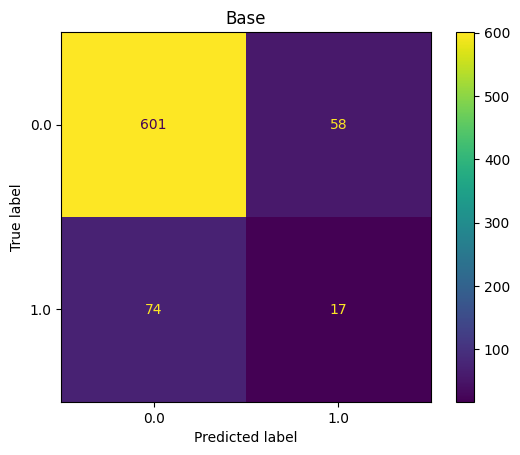

<Figure size 1000x800 with 0 Axes>

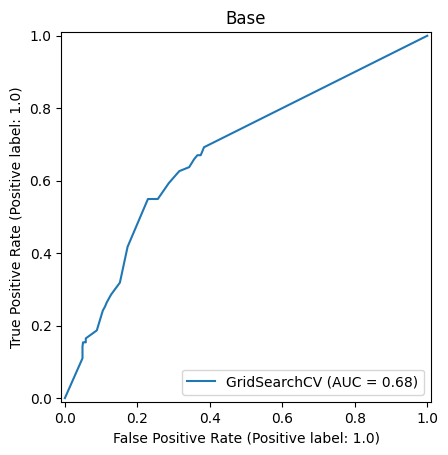

<Figure size 1000x800 with 0 Axes>

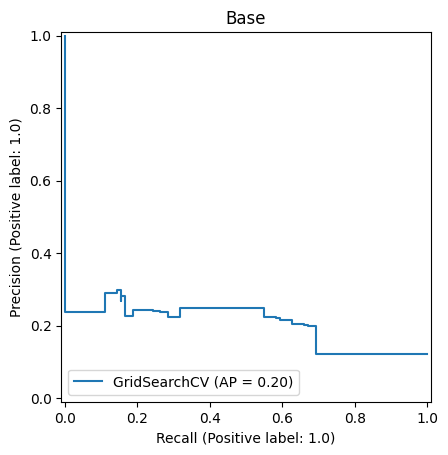

{'max_depth': np.int64(9), 'n_estimators': np.int64(18)}


<Figure size 1000x800 with 0 Axes>

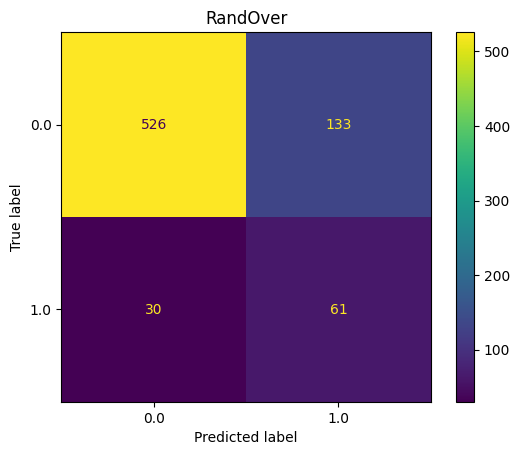

<Figure size 1000x800 with 0 Axes>

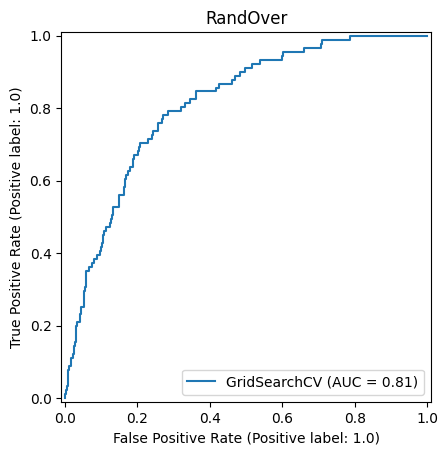

<Figure size 1000x800 with 0 Axes>

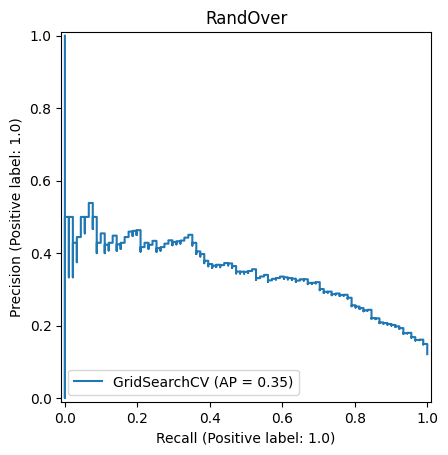

{'max_depth': np.int64(1), 'n_estimators': np.int64(14)}


<Figure size 1000x800 with 0 Axes>

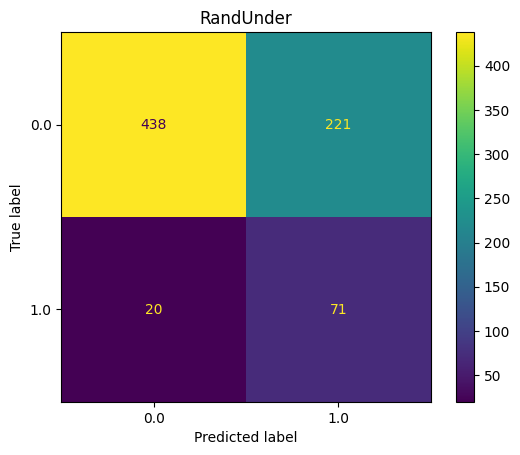

<Figure size 1000x800 with 0 Axes>

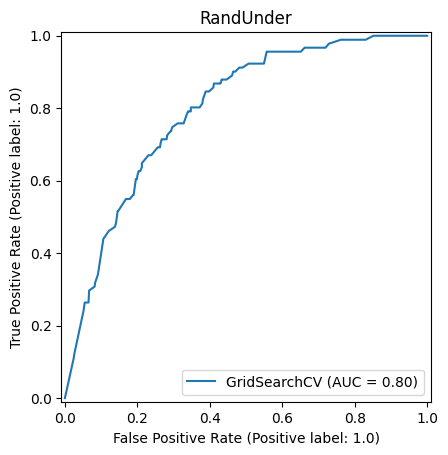

<Figure size 1000x800 with 0 Axes>

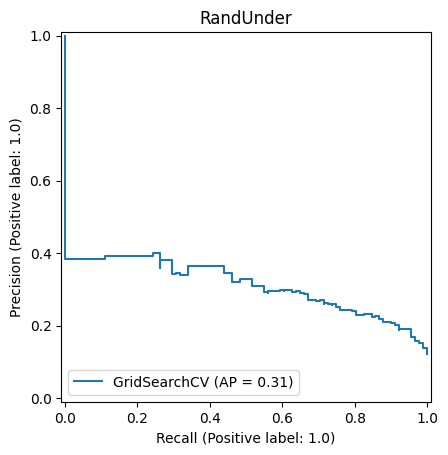

{'max_depth': np.int64(7), 'n_estimators': np.int64(18)}


<Figure size 1000x800 with 0 Axes>

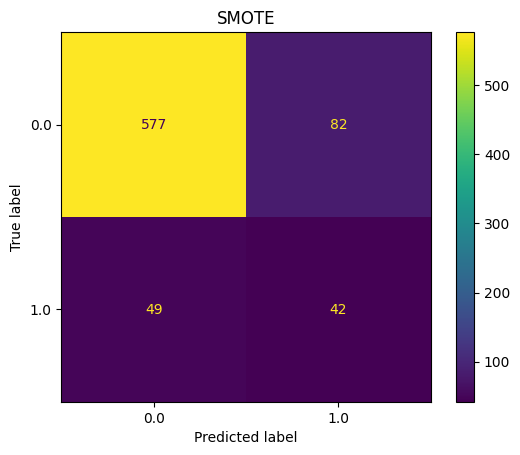

<Figure size 1000x800 with 0 Axes>

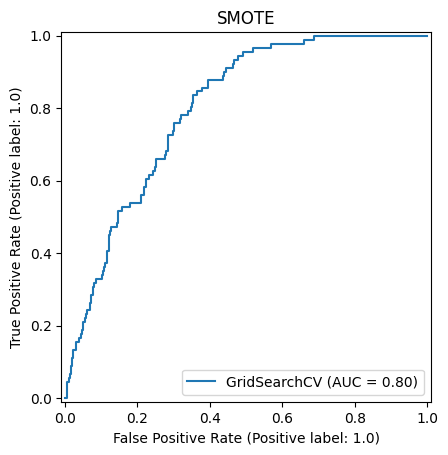

<Figure size 1000x800 with 0 Axes>

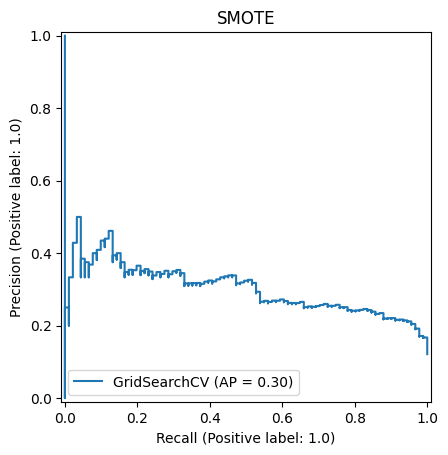

{'max_depth': np.int64(9), 'n_estimators': np.int64(4)}


<Figure size 1000x800 with 0 Axes>

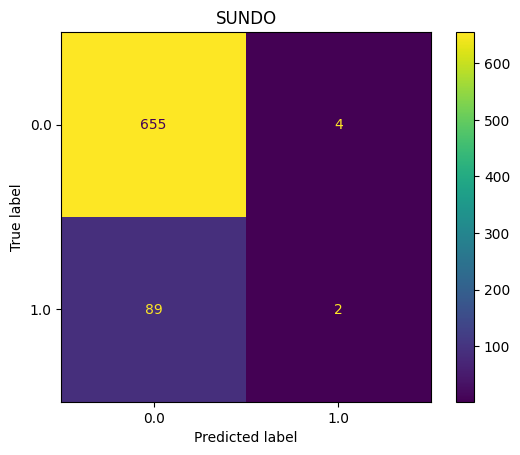

<Figure size 1000x800 with 0 Axes>

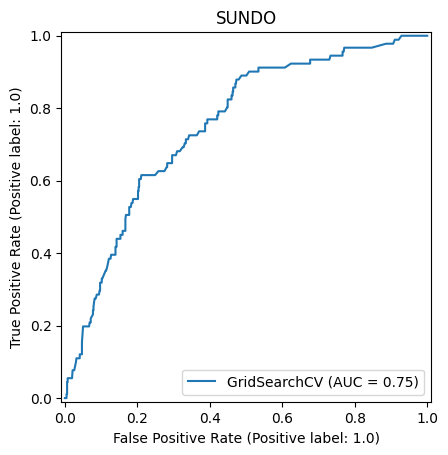

<Figure size 1000x800 with 0 Axes>

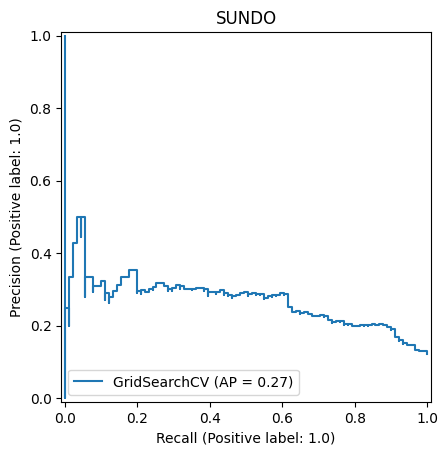

{'max_depth': np.int64(1), 'n_estimators': np.int64(1)}


<Figure size 1000x800 with 0 Axes>

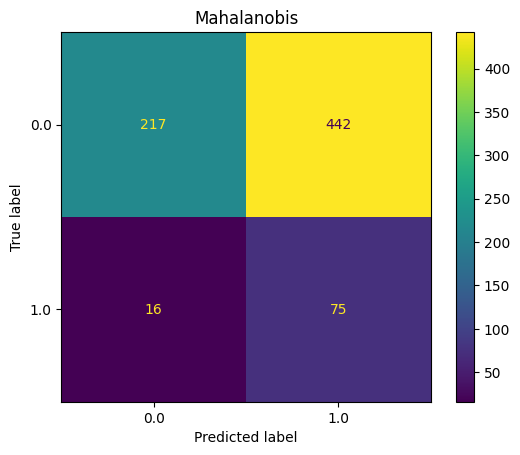

<Figure size 1000x800 with 0 Axes>

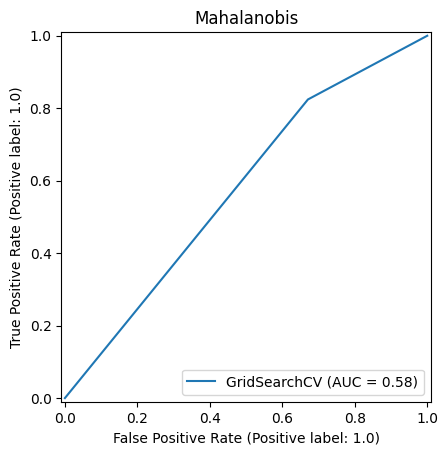

<Figure size 1000x800 with 0 Axes>

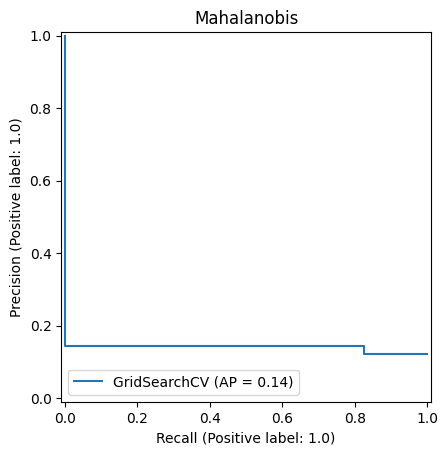

{'max_depth': np.int64(8), 'n_estimators': np.int64(17)}


<Figure size 1000x800 with 0 Axes>

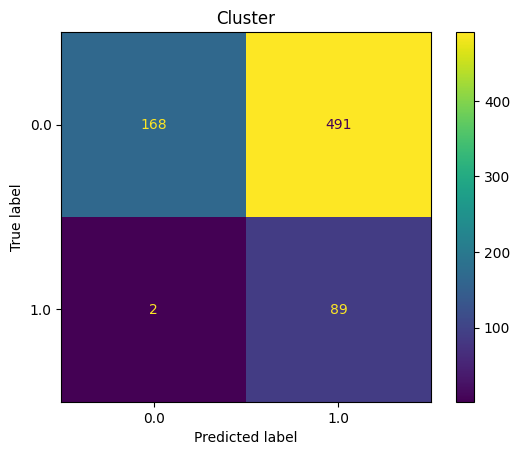

<Figure size 1000x800 with 0 Axes>

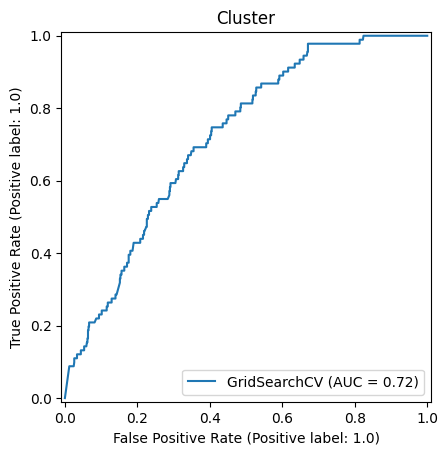

<Figure size 1000x800 with 0 Axes>

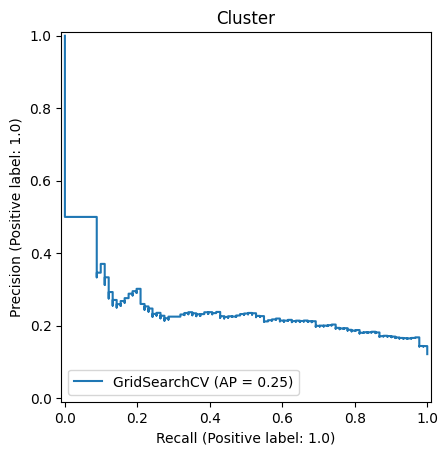

{'max_depth': np.int64(5), 'n_estimators': np.int64(1)}


<Figure size 1000x800 with 0 Axes>

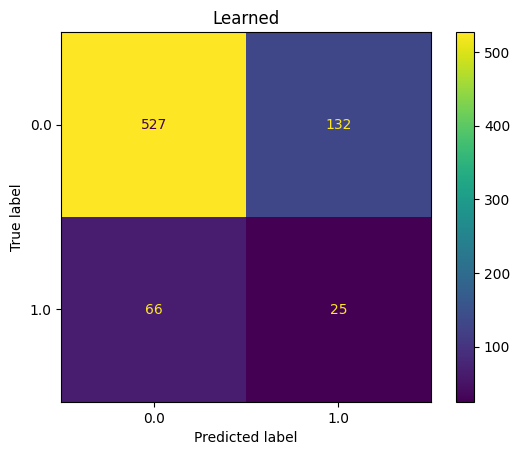

<Figure size 1000x800 with 0 Axes>

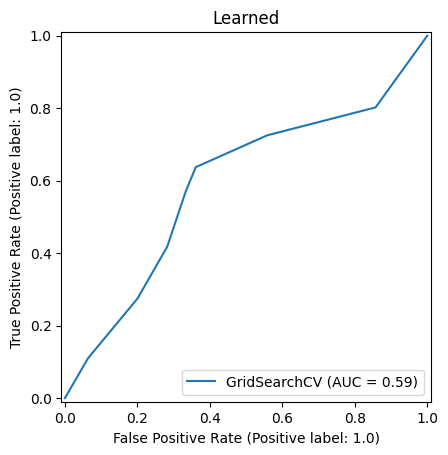

<Figure size 1000x800 with 0 Axes>

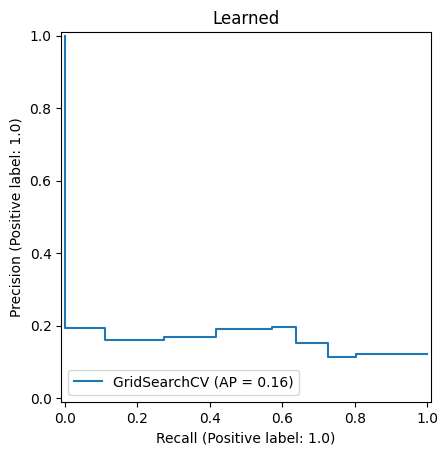

In [16]:
# Start with a random forest.

forest_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])

params = {'max_depth':np.arange(1, 10), 'n_estimators':np.arange(1,20)}

for key, value in training_sets.items():
    model = GridSearchCV(RandomForestClassifier(criterion='entropy', random_state=42), params, cv=10, scoring=ftwo_scorer)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        print(model.best_params_)
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        print(model.best_params_)
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    forest_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    forest_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-pr.png');
    plt.show()

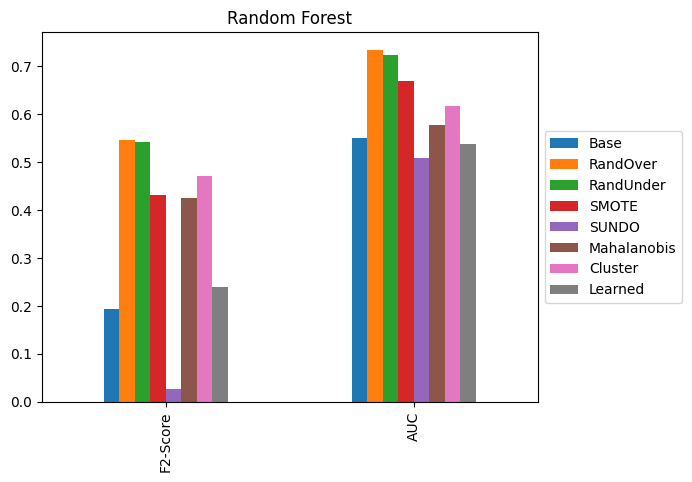

,F2-Score,AUC
Base,0.193622,0.549401
RandOver,0.546595,0.734254
RandUnder,0.541159,0.722432
SMOTE,0.430328,0.668554
SUNDO,0.027027,0.507954
Mahalanobis,0.425653,0.576731
Cluster,0.471398,0.616477
Learned,0.239923,0.537211


In [17]:
forest_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Random Forest');
plt.savefig('img/final-cdc-forest-metrics.png', bbox_inches = 'tight')
plt.show()
forest_metrics

### Moving on to logistic regression.

Resampler: Base


<Figure size 1000x800 with 0 Axes>

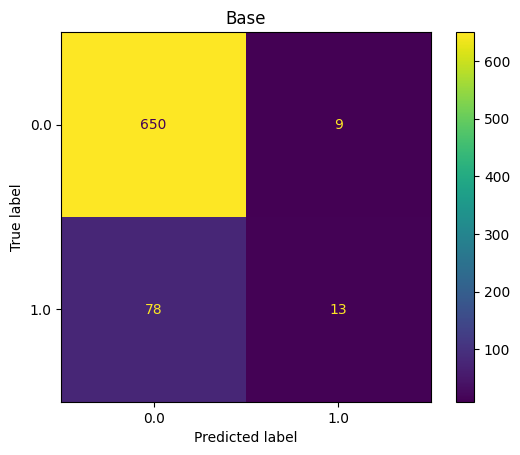

<Figure size 1000x800 with 0 Axes>

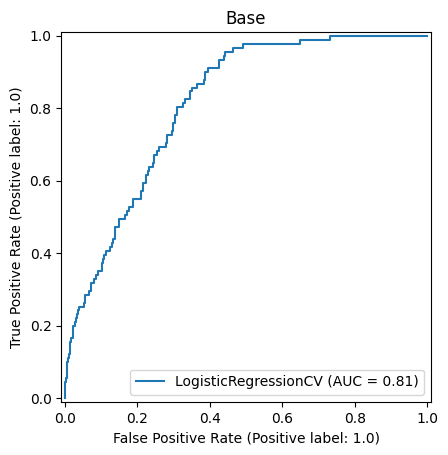

<Figure size 1000x800 with 0 Axes>

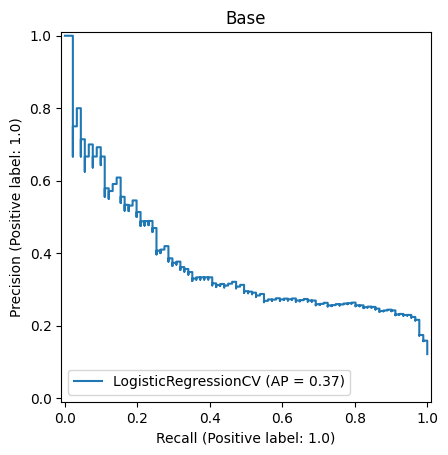

Resampler: RandOver


<Figure size 1000x800 with 0 Axes>

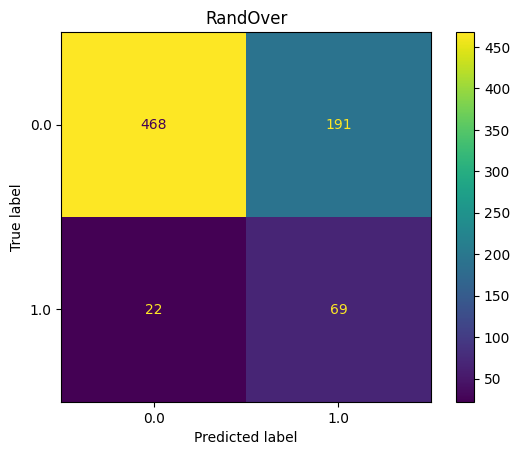

<Figure size 1000x800 with 0 Axes>

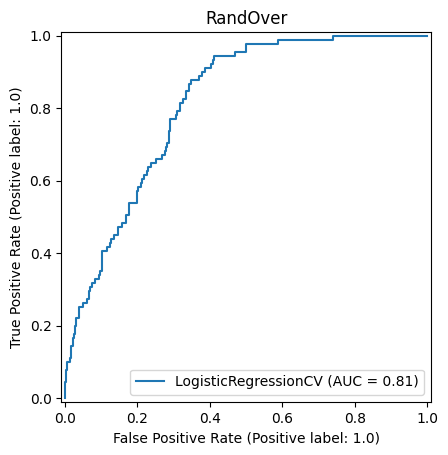

<Figure size 1000x800 with 0 Axes>

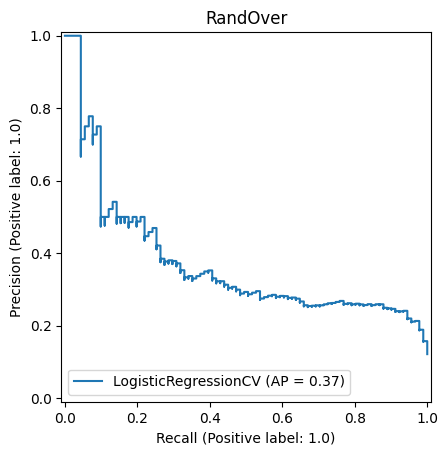

Resampler: RandUnder


<Figure size 1000x800 with 0 Axes>

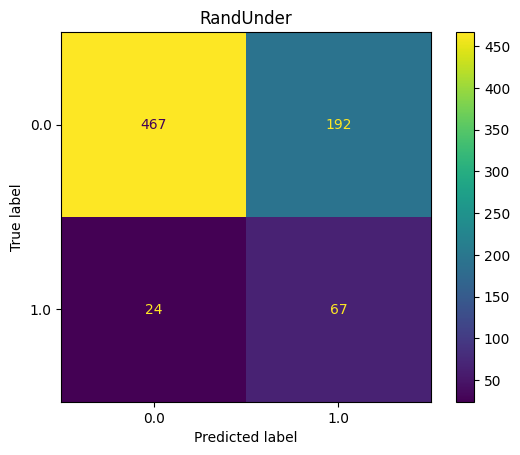

<Figure size 1000x800 with 0 Axes>

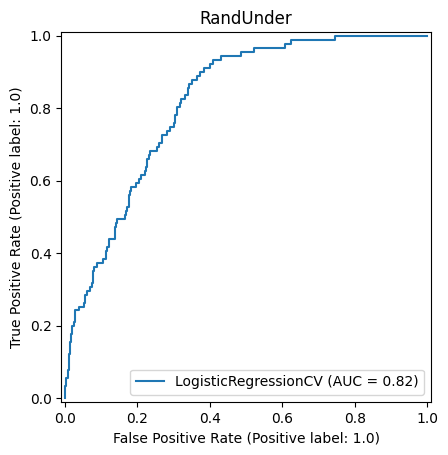

<Figure size 1000x800 with 0 Axes>

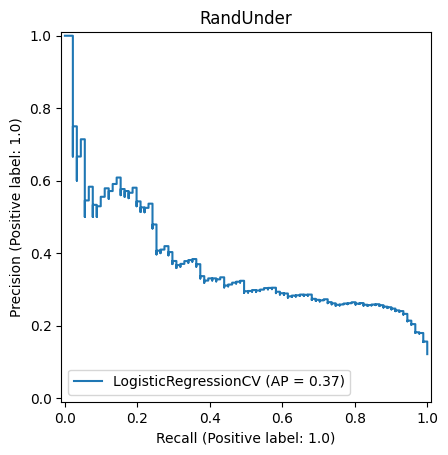

Resampler: SMOTE


<Figure size 1000x800 with 0 Axes>

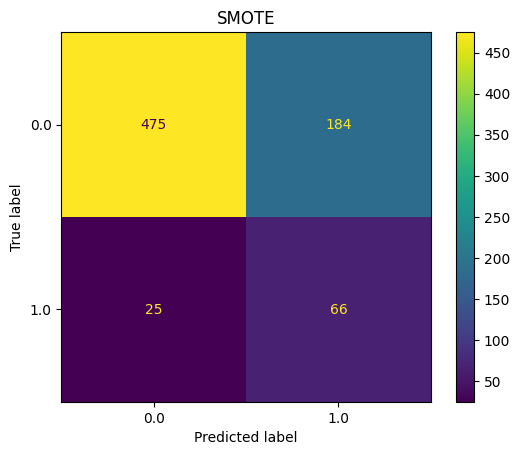

<Figure size 1000x800 with 0 Axes>

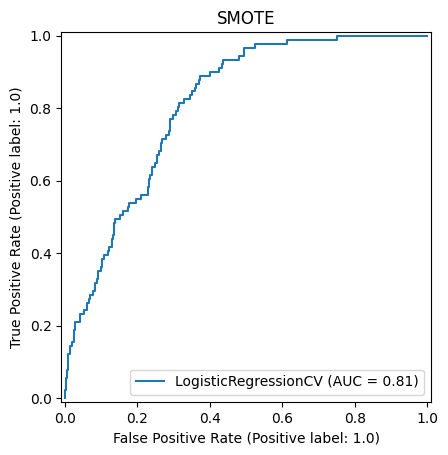

<Figure size 1000x800 with 0 Axes>

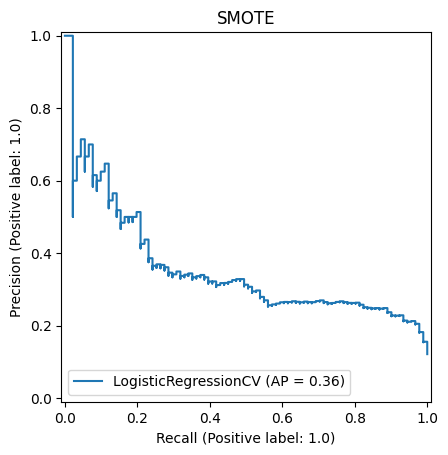

Resampler: SUNDO


<Figure size 1000x800 with 0 Axes>

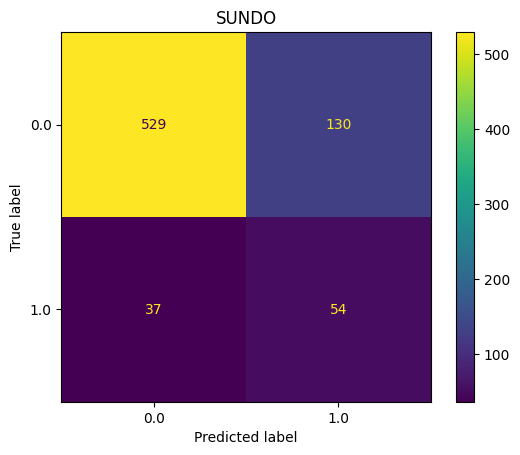

<Figure size 1000x800 with 0 Axes>

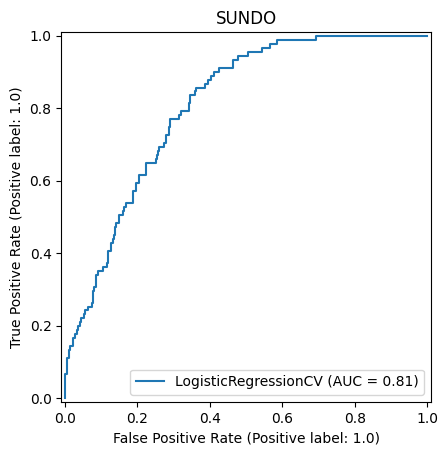

<Figure size 1000x800 with 0 Axes>

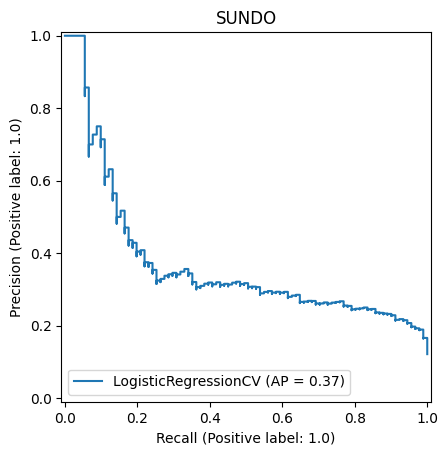

Resampler: Mahalanobis


<Figure size 1000x800 with 0 Axes>

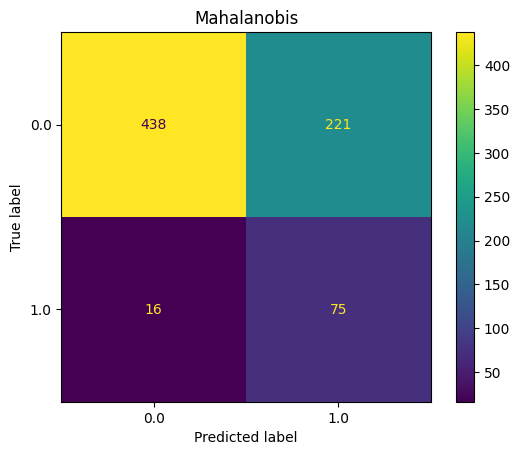

<Figure size 1000x800 with 0 Axes>

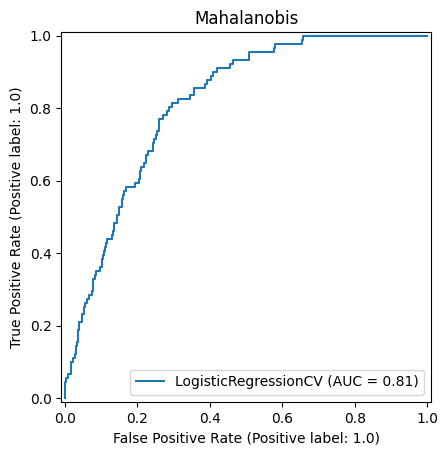

<Figure size 1000x800 with 0 Axes>

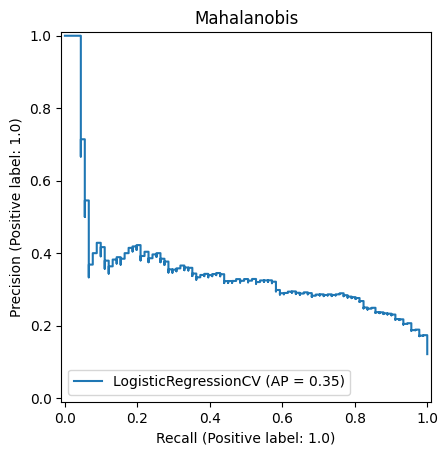

Resampler: Cluster


<Figure size 1000x800 with 0 Axes>

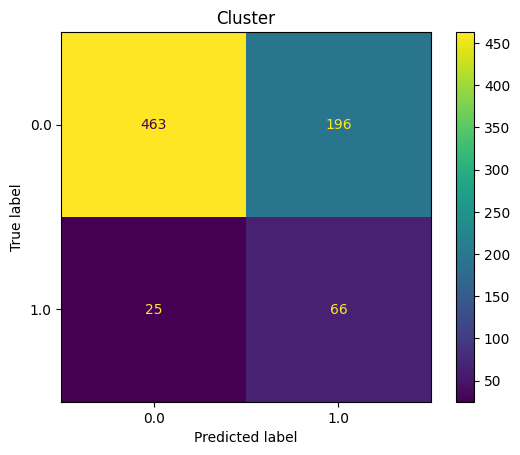

<Figure size 1000x800 with 0 Axes>

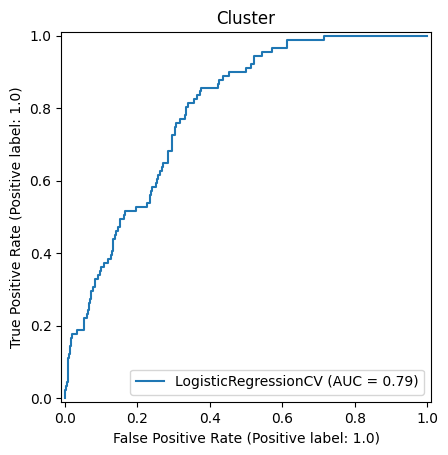

<Figure size 1000x800 with 0 Axes>

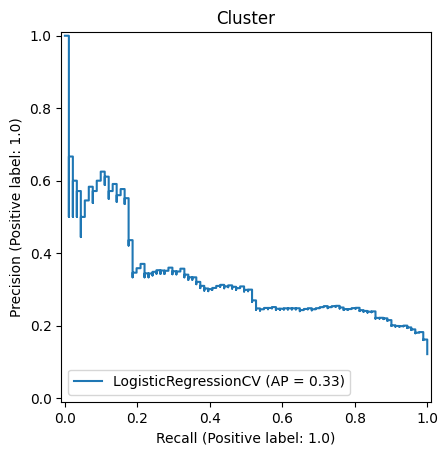

Resampler: Learned


<Figure size 1000x800 with 0 Axes>

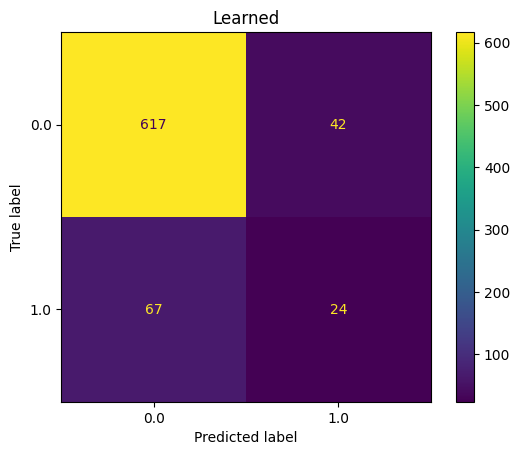

<Figure size 1000x800 with 0 Axes>

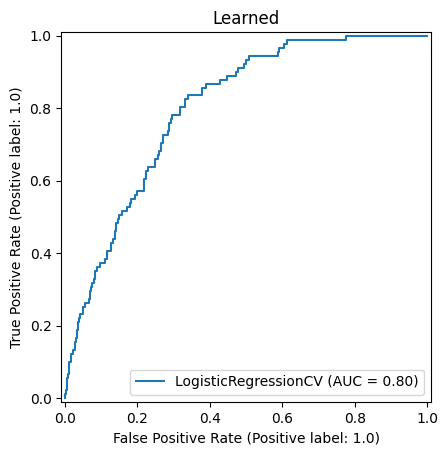

<Figure size 1000x800 with 0 Axes>

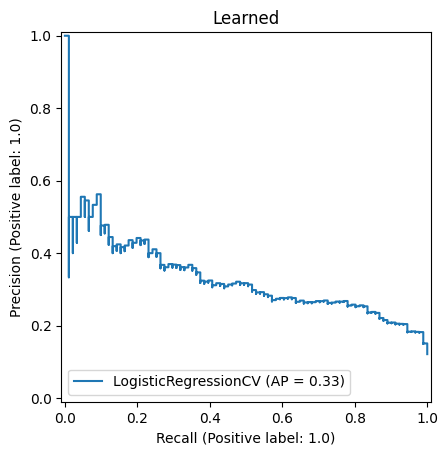

In [18]:
regress_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])
for key, value in training_sets.items():
    model = LogisticRegressionCV(random_state=42, scoring=ftwo_scorer)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    regress_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    regress_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    print(f"Resampler: {key}")
    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-regress-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-regress-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-regress-pr.png');
    plt.show()

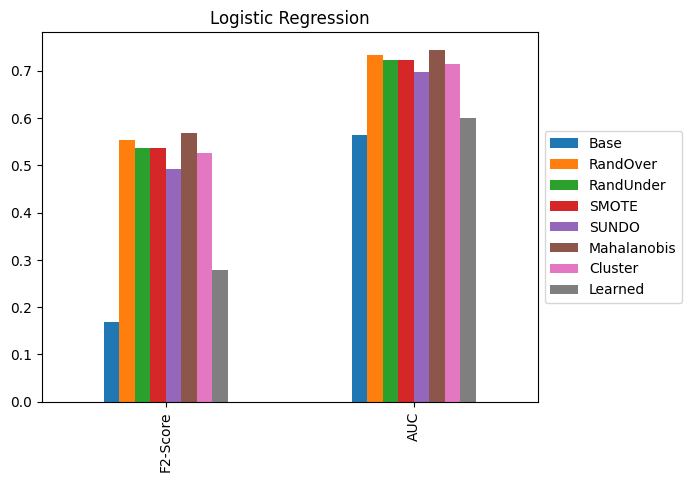

,F2-Score,AUC
Base,0.168394,0.5646
RandOver,0.552885,0.734204
RandUnder,0.537721,0.722457
SMOTE,0.537459,0.723032
SUNDO,0.492701,0.698069
Mahalanobis,0.568182,0.74441
Cluster,0.527157,0.713927
Learned,0.27907,0.600002


In [19]:
regress_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Logistic Regression');
plt.savefig('img/final-cdc-regress-metrics.png', bbox_inches = 'tight')
plt.show()
regress_metrics

### A Multi-Layer Perceptron

Resampler: Base


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

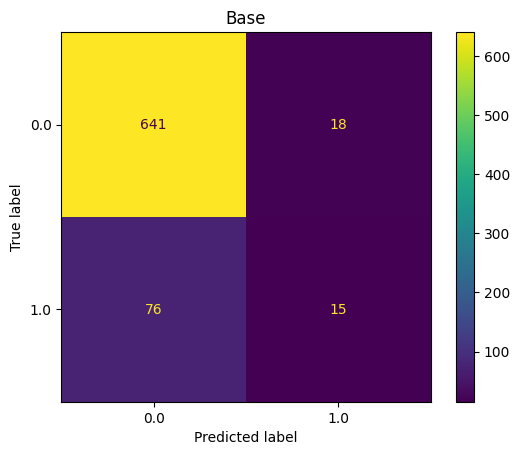

<Figure size 1000x800 with 0 Axes>

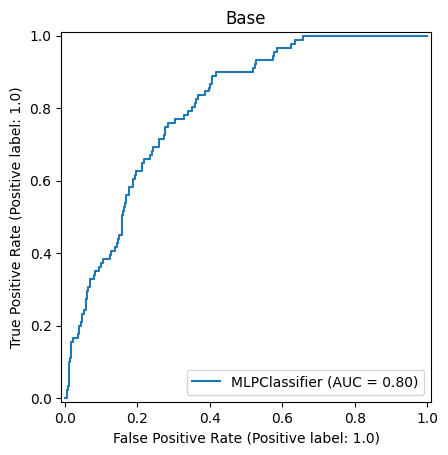

<Figure size 1000x800 with 0 Axes>

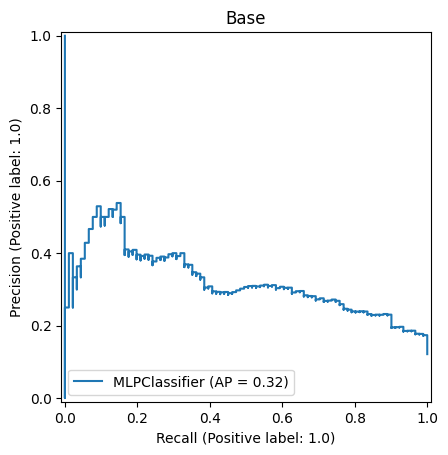

Resampler: RandOver


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

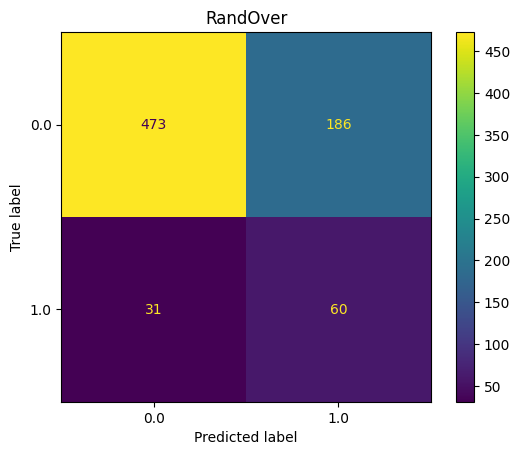

<Figure size 1000x800 with 0 Axes>

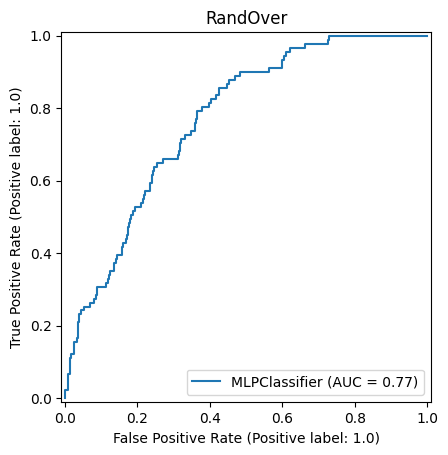

<Figure size 1000x800 with 0 Axes>

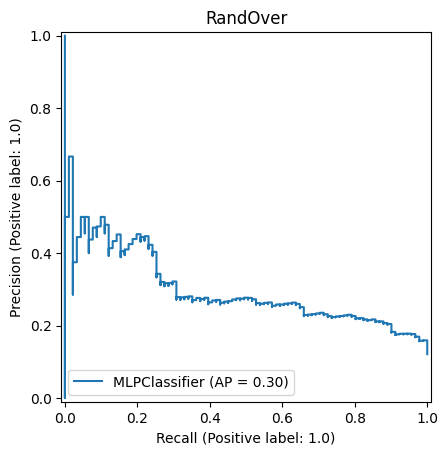

Resampler: RandUnder


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

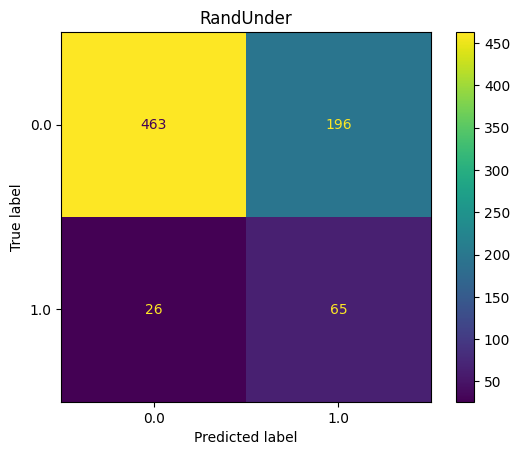

<Figure size 1000x800 with 0 Axes>

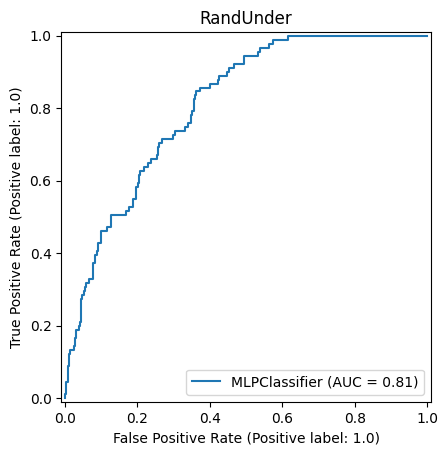

<Figure size 1000x800 with 0 Axes>

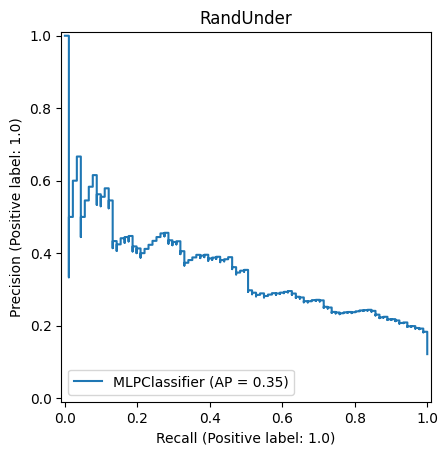

Resampler: SMOTE


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

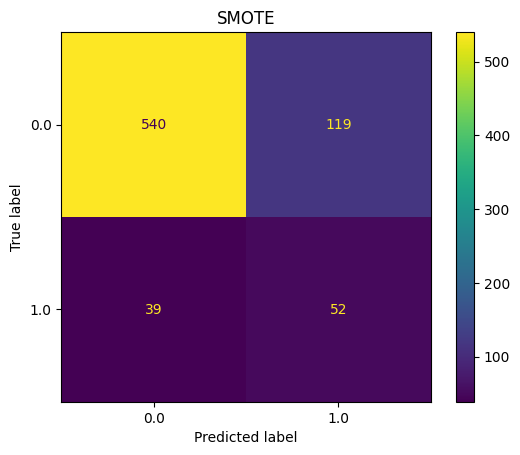

<Figure size 1000x800 with 0 Axes>

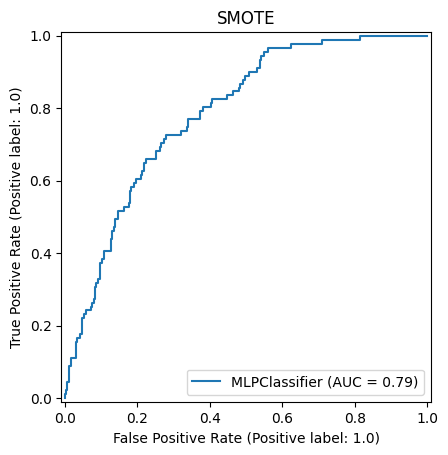

<Figure size 1000x800 with 0 Axes>

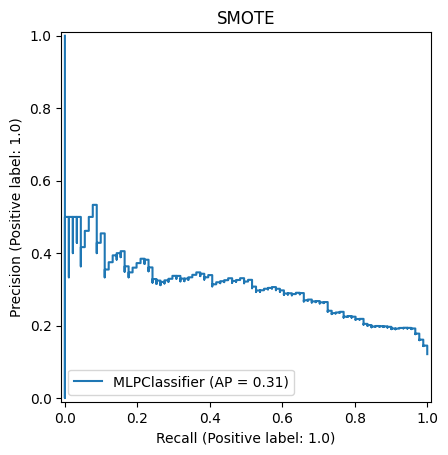

Resampler: SUNDO


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

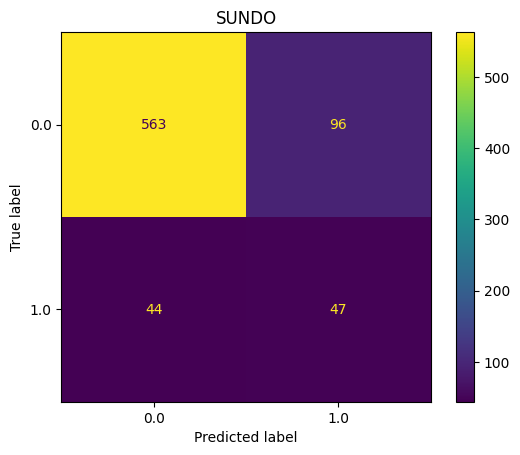

<Figure size 1000x800 with 0 Axes>

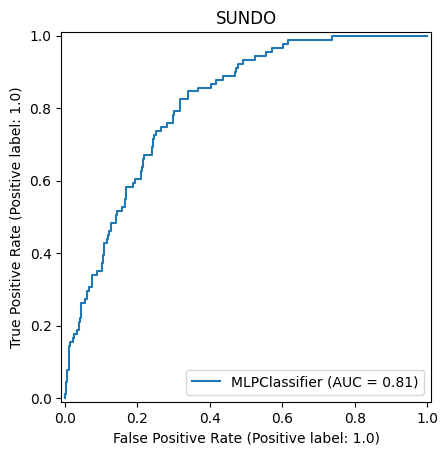

<Figure size 1000x800 with 0 Axes>

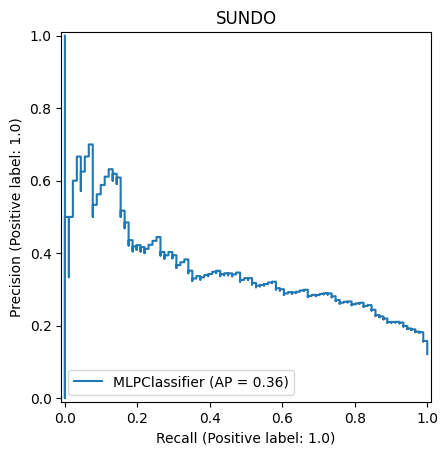

Resampler: Mahalanobis


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

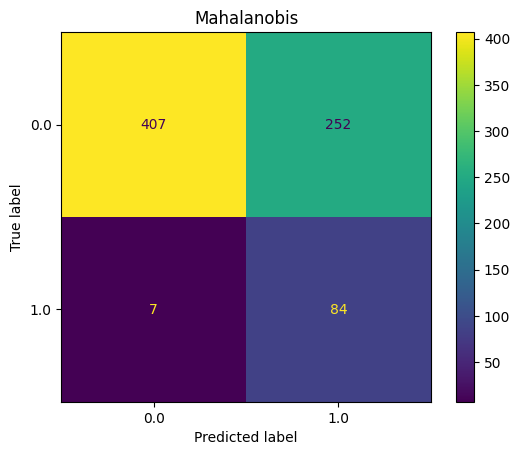

<Figure size 1000x800 with 0 Axes>

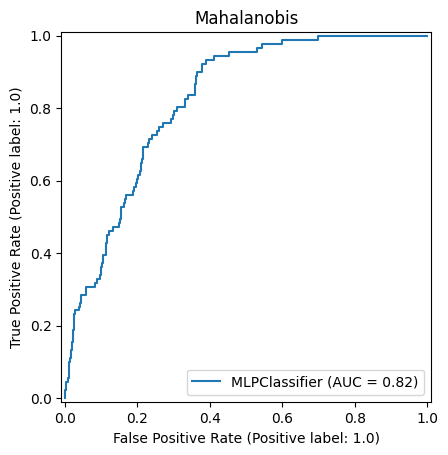

<Figure size 1000x800 with 0 Axes>

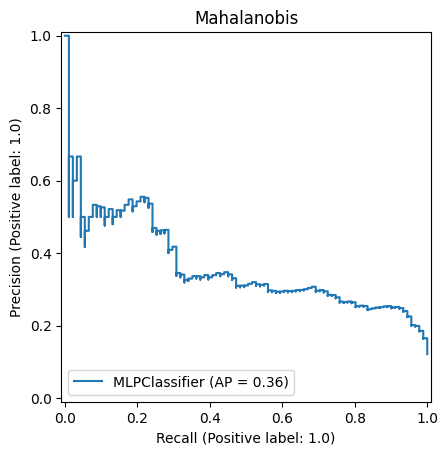

Resampler: Cluster


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

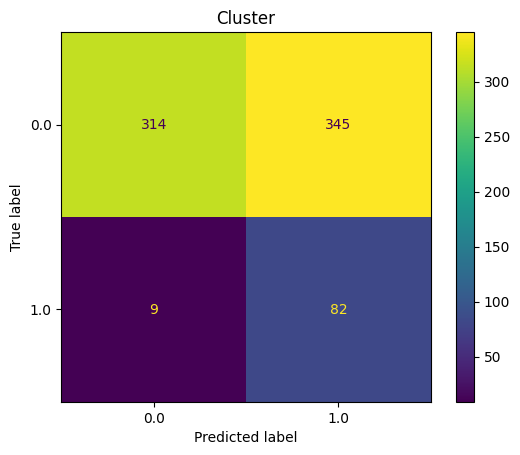

<Figure size 1000x800 with 0 Axes>

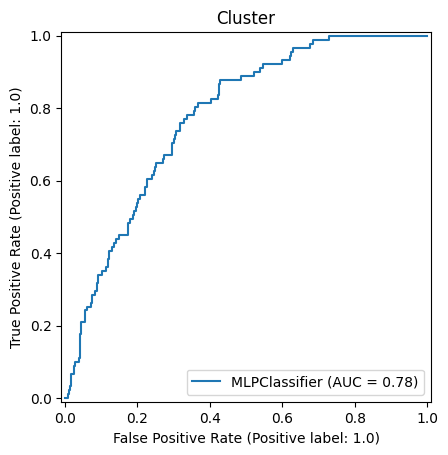

<Figure size 1000x800 with 0 Axes>

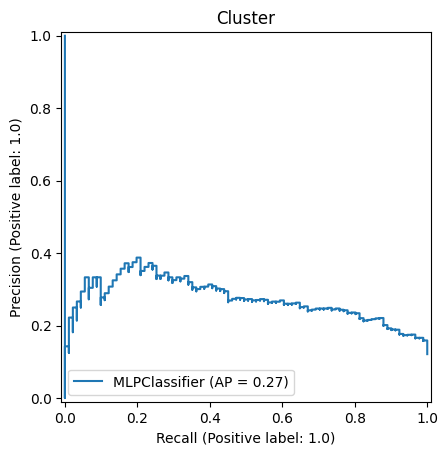

Resampler: Learned


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

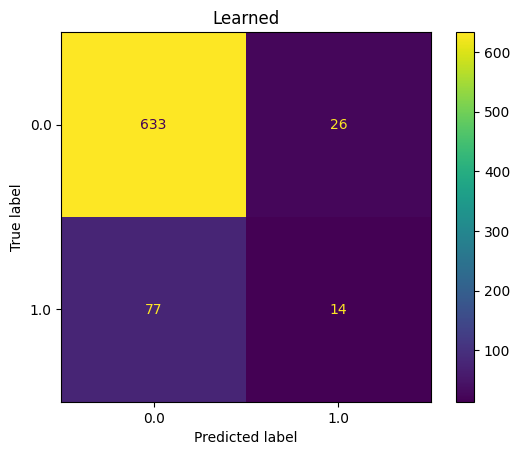

<Figure size 1000x800 with 0 Axes>

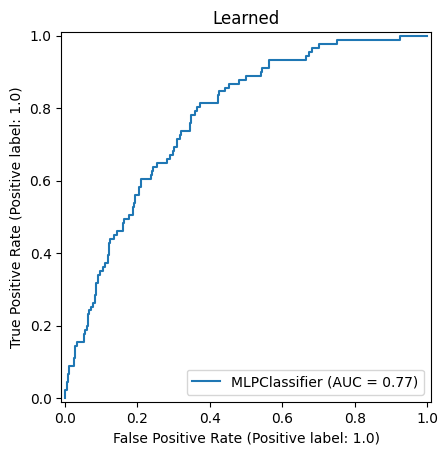

<Figure size 1000x800 with 0 Axes>

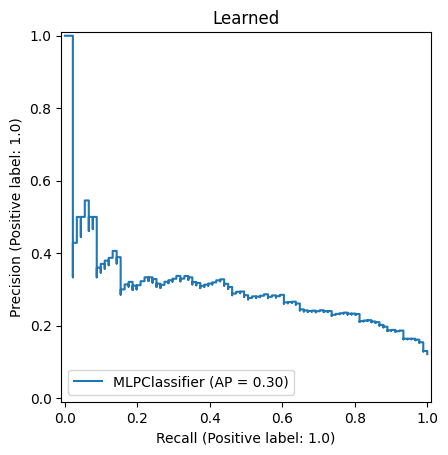

In [20]:
neural_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])
for key, value in training_sets.items():
    model = MLPClassifier(random_state=42)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    neural_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    neural_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    print(f"Resampler: {key}")
    fig = plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-neural-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-neural-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-neural-pr.png');
    plt.show()

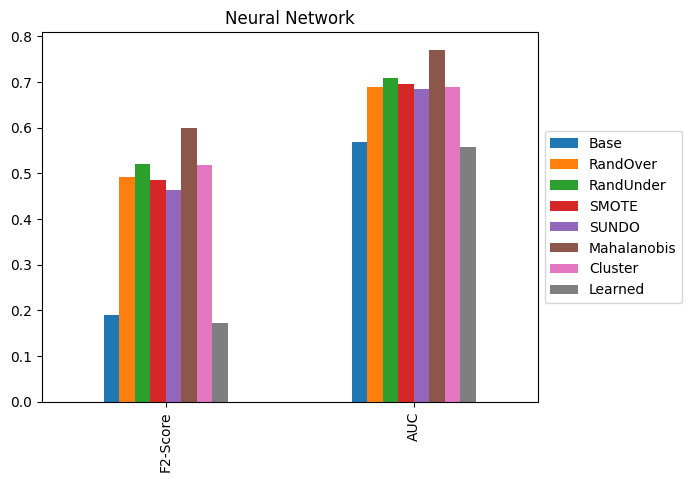

,F2-Score,AUC
Base,0.188917,0.568761
RandOver,0.491803,0.688547
RandUnder,0.52,0.708433
SMOTE,0.485981,0.695426
SUNDO,0.463511,0.685404
Mahalanobis,0.6,0.77034
Cluster,0.518331,0.688789
Learned,0.173267,0.557196


In [21]:
neural_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Neural Network');
plt.savefig('img/final-cdc-neural-metrics.png', bbox_inches = 'tight')
plt.show()
neural_metrics

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

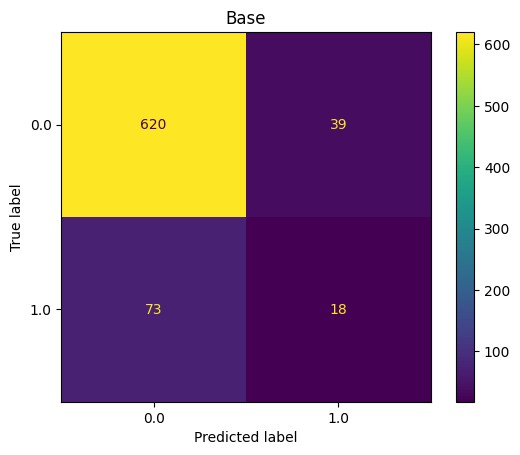

<Figure size 1000x800 with 0 Axes>

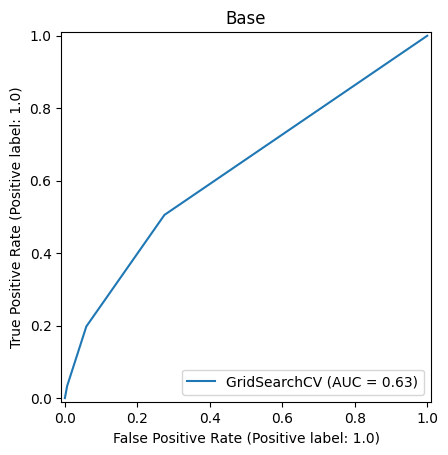

<Figure size 1000x800 with 0 Axes>

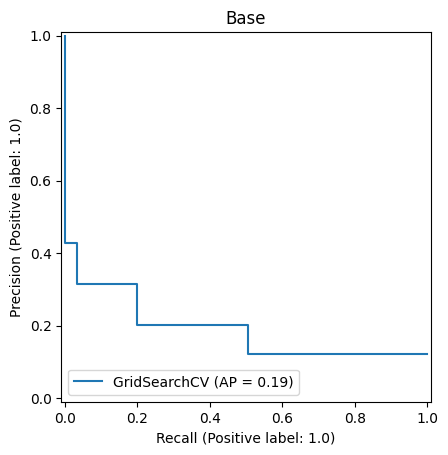

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

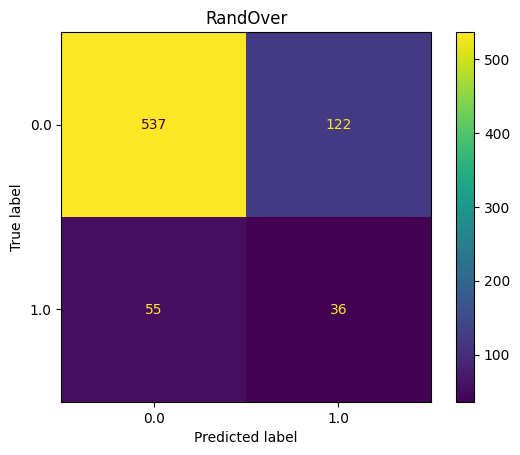

<Figure size 1000x800 with 0 Axes>

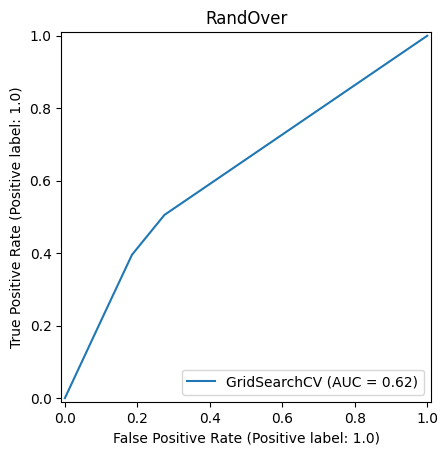

<Figure size 1000x800 with 0 Axes>

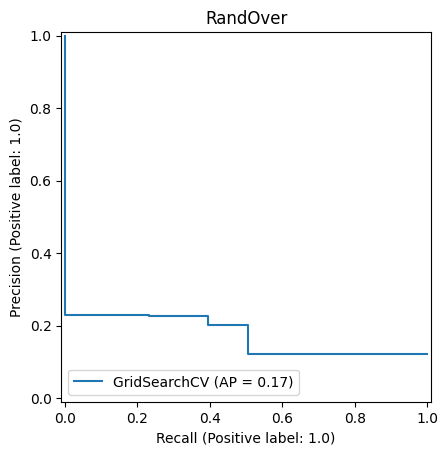

{'n_neighbors': np.int64(29)}


<Figure size 1000x800 with 0 Axes>

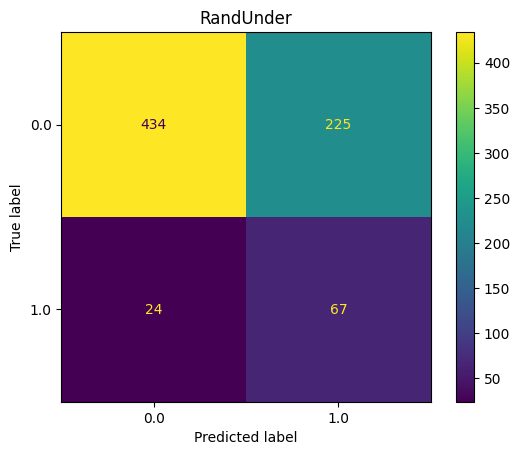

<Figure size 1000x800 with 0 Axes>

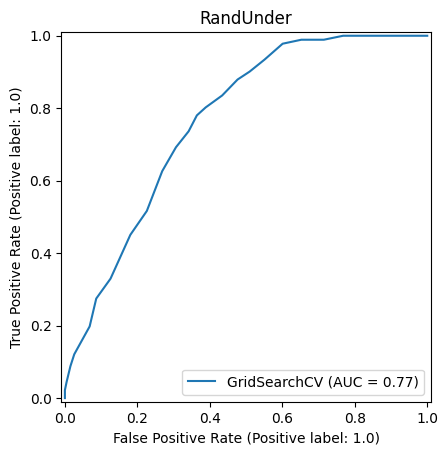

<Figure size 1000x800 with 0 Axes>

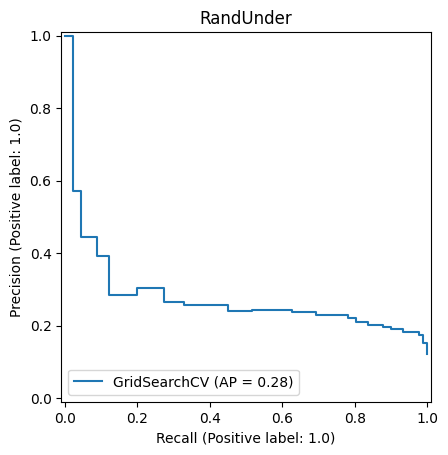

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

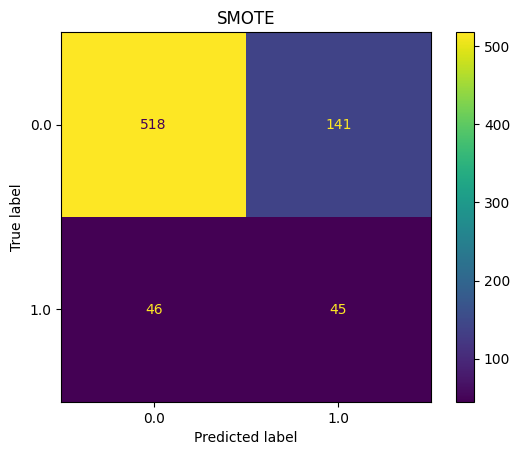

<Figure size 1000x800 with 0 Axes>

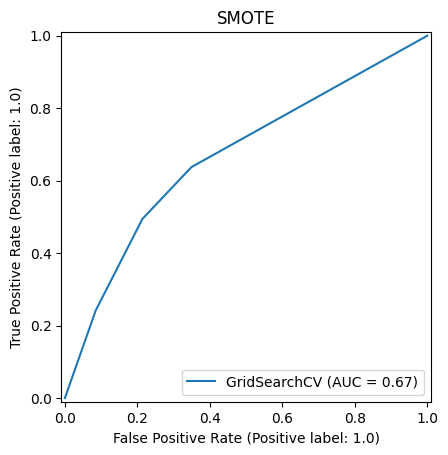

<Figure size 1000x800 with 0 Axes>

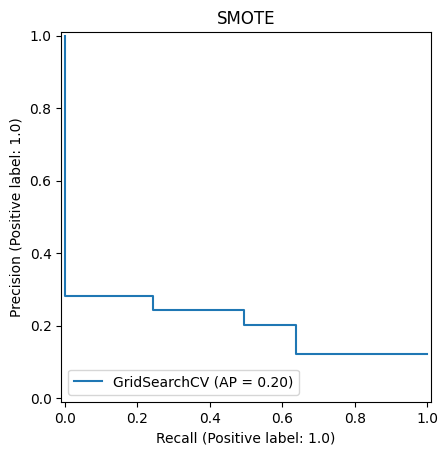

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

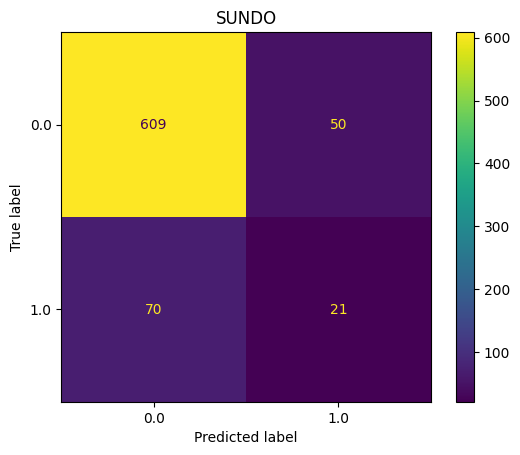

<Figure size 1000x800 with 0 Axes>

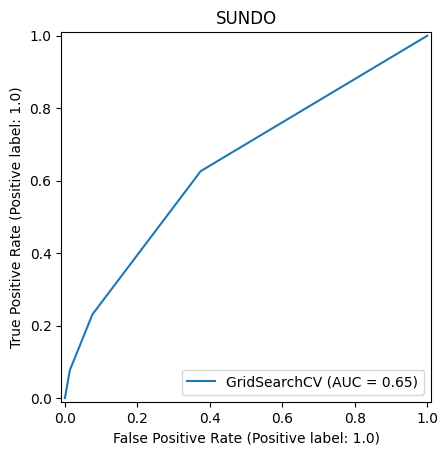

<Figure size 1000x800 with 0 Axes>

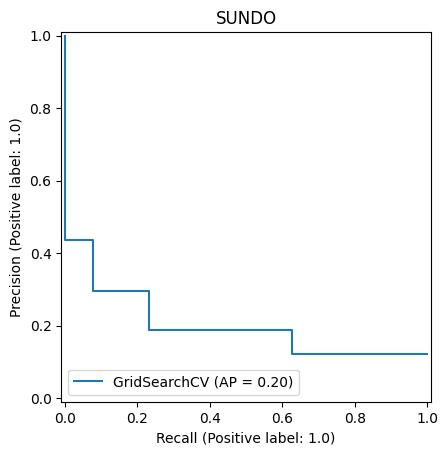

{'n_neighbors': np.int64(11)}


<Figure size 1000x800 with 0 Axes>

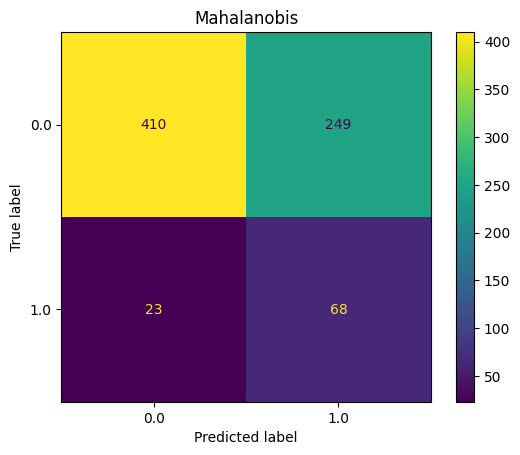

<Figure size 1000x800 with 0 Axes>

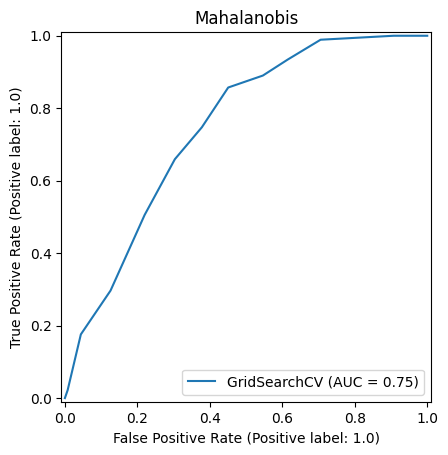

<Figure size 1000x800 with 0 Axes>

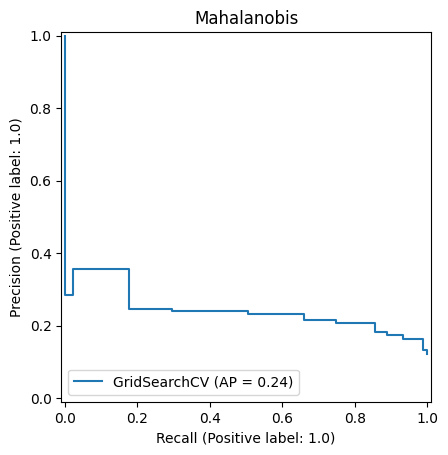

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

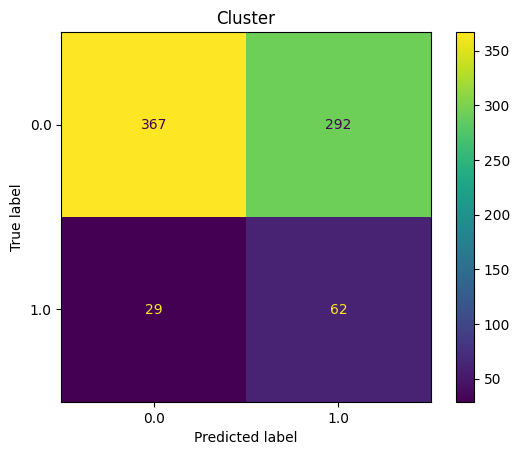

<Figure size 1000x800 with 0 Axes>

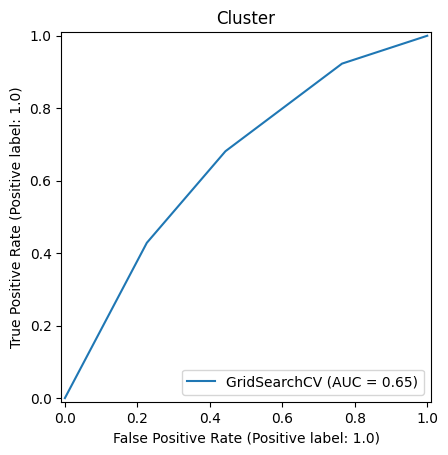

<Figure size 1000x800 with 0 Axes>

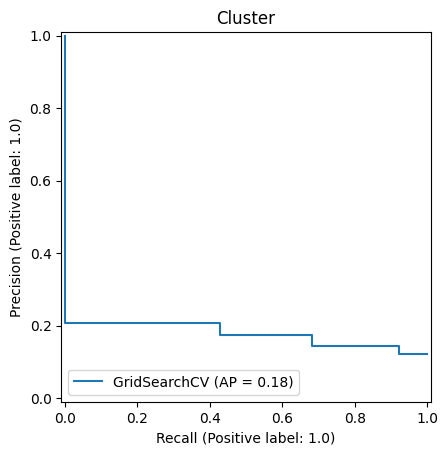

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

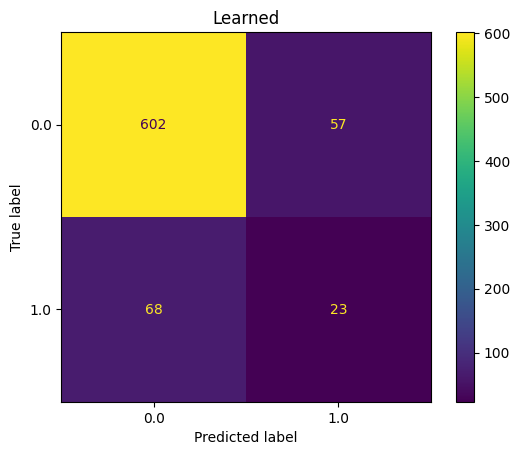

<Figure size 1000x800 with 0 Axes>

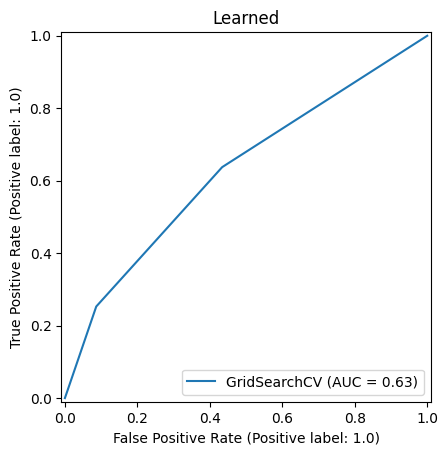

<Figure size 1000x800 with 0 Axes>

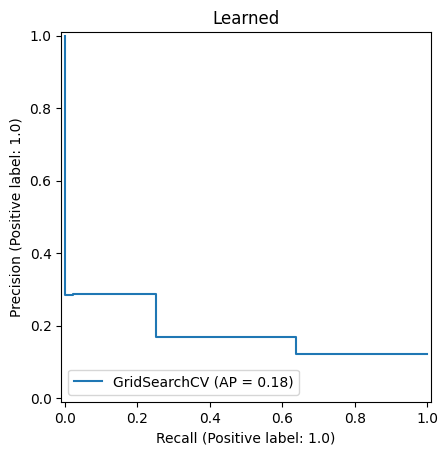

In [23]:
neighbor_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])

params = {'n_neighbors':np.arange(3, 30)}

for key, value in training_sets.items():
    model = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring=ftwo_scorer)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        print(model.best_params_)
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        print(model.best_params_)
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    neighbor_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    neighbor_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'img/final-cdc-{key}-forest-pr.png');
    plt.show()

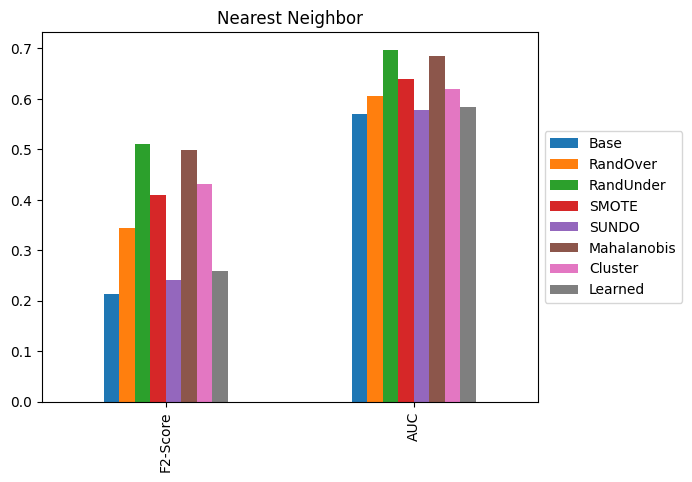

,F2-Score,AUC
Base,0.213777,0.569311
RandOver,0.344828,0.605238
RandUnder,0.510671,0.697419
SMOTE,0.409091,0.640272
SUNDO,0.241379,0.577448
Mahalanobis,0.499266,0.684704
Cluster,0.431755,0.619112
Learned,0.259009,0.583126


In [24]:
neighbor_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Nearest Neighbor');
plt.savefig('img/final-cdc-neighbor-metrics.png', bbox_inches = 'tight')
plt.show()
neighbor_metrics